In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pickle
import matplotlib.pyplot as plt
import os
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import torch.nn.functional as F
from early_stopping_pytorch import EarlyStopping

In [2]:
# Check PyTorch version
print("PyTorch Version: ", torch.__version__)
# Check GPU
if torch.cuda.is_available():
    print("GPU Device Name: ", torch.cuda.get_device_name(0))
else:
    print("No GPU available.")

PyTorch Version:  2.1.1
GPU Device Name:  Tesla V100-PCIE-32GB


In [3]:
# Load data
with open('/scratch/da3245/datasets/timeseries_voltage/stratified_no_overlap.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [4]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (59233, 200)
y_train shape: (59233, 200)
X_val shape: (10453, 200)
y_val shape: (10453, 200)
X_test shape: (12298, 200)
y_test shape: (12298, 200)


In [5]:
# Convert back to tensors for DataLoader
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)  # Add channel dimension
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)  
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, device, num_epochs=50, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        num_train_batches = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 2), labels.view(-1))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            num_train_batches += 1

        train_losses.append(epoch_train_loss / num_train_batches)

        model.eval()
        epoch_val_loss = 0.0
        num_val_batches = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).permute(0, 2, 1)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                epoch_val_loss += loss.item()
                num_val_batches += 1

        val_losses.append(epoch_val_loss / num_val_batches)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    precision, recall, f1, auc = evaluate_model(model, test_loader, device)
    return f1


train_sizes = np.linspace(0.1, 1.0, 10)  # 10 steps from 10% to 100% of training data
f1_scores = []
for train_size in train_sizes:
    num_train_samples = int(len(X_train) * train_size)
    train_subset_indices = np.random.choice(len(X_train), num_train_samples, replace=False)
    X_train_subset = X_train[train_subset_indices]
    y_train_subset = y_train[train_subset_indices]

    train_subset_dataset = TensorDataset(X_train_subset, y_train_subset)
    train_subset_loader = DataLoader(train_subset_dataset, batch_size=32, shuffle=True)

    #Train and evaluate the model
    model = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout).to(device)
    f1 = train_and_evaluate(model, train_subset_loader, val_loader, test_loader, device)
    f1_scores.append(f1)

NameError: name 'TemporalConvNet' is not defined

In [7]:
#model = SequenceLabelingRNN(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
model = AttentionLSTM(input_size, hidden_size, num_layers, output_size, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels[:,0])
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

NameError: name 'AttentionLSTM' is not defined

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 1
#num_channels = [32, 64, 128]
num_channels = [32, 64, 128, 256]
kernel_size = 3
dropout = 0.002

model = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
early_stopping = EarlyStopping(patience=10, verbose=True) #https://github.com/Bjarten/early-stopping-pytorch

#from torchinfo import summary
#print(summary(model, input_size=(32,1,200))) 

In [43]:
# Training loop
num_epochs = 50
val_interval = 1
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device).permute(0,2,1)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1,2), labels.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(loss.item())
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device).permute(0,2,1)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
            print("Saving best model...")
        else:
            early_stopping(val_loss, model)
    
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

Epoch [1/50], Loss: 0.0327
Epoch [1/50], Train Loss: 0.0109, Val Loss: 0.0136
Validation loss decreased (inf --> 0.013646).  Saving model ...
Epoch [2/50], Loss: 0.0044
Epoch [2/50], Train Loss: 0.0122, Val Loss: 0.0133
Validation loss decreased (0.013646 --> 0.013296).  Saving model ...
Epoch [3/50], Loss: 0.0037
Epoch [3/50], Train Loss: 0.0105, Val Loss: 0.0130
Validation loss decreased (0.013296 --> 0.012979).  Saving model ...
Epoch [4/50], Loss: 0.0260
Epoch [4/50], Train Loss: 0.0102, Val Loss: 0.0128
Validation loss decreased (0.012979 --> 0.012758).  Saving model ...
Epoch [5/50], Loss: 0.0035
Epoch [5/50], Train Loss: 0.0126, Val Loss: 0.0126
Validation loss decreased (0.012758 --> 0.012550).  Saving model ...
Epoch [6/50], Loss: 0.0076
Epoch [6/50], Train Loss: 0.0126, Val Loss: 0.0128
EarlyStopping counter: 1 out of 10
Epoch [7/50], Loss: 0.0020
Epoch [7/50], Train Loss: 0.0097, Val Loss: 0.0123
Validation loss decreased (0.012550 --> 0.012301).  Saving model ...
Epoch [8/5

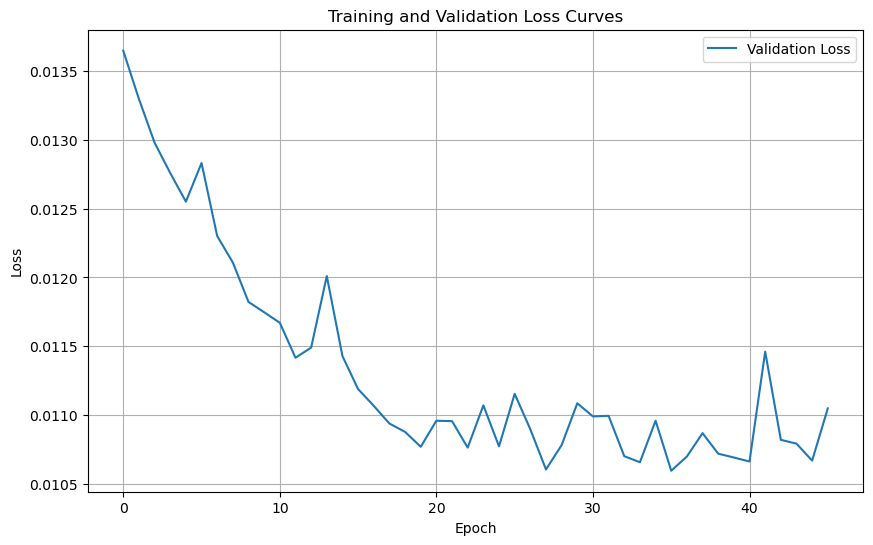

In [44]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
#plt.plot([loss/len(train_loader) for loss in train_losses], label='Training Loss')
#plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from torchviz import make_dot
import torchviz
# Dummy input for visualization
dummy_input = torch.randn(1, 200, 1).to(device)  # [batch_size, seq_len, input_channels]
dummy_input = dummy_input.permute(0, 2, 1)  # Match input format for Conv1d (B, C, L)

# Forward pass
output = model(dummy_input)

# Generate and save visualization
#graph = make_dot(output, params=dict(model.named_parameters()))
dot = torchviz.make_dot(
        output, 
        params=dict(model.named_parameters()),
        show_attrs=False,  # Hide node attributes
        show_saved=False   # Hide saved tensors
    )
simplify=True
if simplify:
        dot.graph_attr.update({
            'rankdir': 'TB',    # Top to Bottom layout
            'size': '8,5',      # Reduce overall graph size
            'dpi': '300',       # Increase resolution
        })
        
        # Reduce node complexity
        dot.node_attr.update({
            'shape': 'box',     # Simpler node shape
            'style': 'filled',  # Fill color
            'fillcolor': 'lightblue',  # Light background
            'fontsize': '10',   # Smaller font
        })
        
        # Reduce edge complexity
        dot.edge_attr.update({
            'color': 'gray',    # Muted edge color
            'penwidth': '0.5',  # Thinner edges
        })
dot.render("TemporalConvNet", format="png")  # Save as PNG


'TemporalConvNet.png'

### Evaluation

In [9]:
from sklearn.metrics import precision_recall_curve

def evaluate_model(model, data_loader, device):
    """Evaluates the model and computes various metrics."""
    model.eval()
    all_true_labels = []
    all_predicted_labels = []
    all_probabilities = []
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #outputs = model(inputs.permute(0,2,1))
            loss = criterion(outputs.view(-1, 2), labels.view(-1))
            test_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=2) #Softmax to get probabilities
            threshold = 0.5325 # Example: Lower threshold
            predicted = (probabilities[:, :, 1] > threshold).long()
            #_, predicted = torch.max(outputs.data, 2)

            all_true_labels.extend(labels.view(-1).cpu().numpy())
            all_predicted_labels.extend(predicted.view(-1).cpu().numpy())
            all_probabilities.extend(probabilities.view(-1,2).cpu().numpy())
            total += labels.view(-1).size(0)
            correct += (predicted.view(-1) == labels.view(-1)).sum().item()
    
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")
    # Calculate metrics
    accuracy=100 * correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_predicted_labels, average="binary", zero_division=0
    )
    try:
        auc = roc_auc_score(all_true_labels, np.array(all_probabilities)[:, 1]) #Calculate AUC
    except ValueError:
        auc = np.nan
        print("Only one class present in y_true. ROC AUC score is not defined in that case.")

    probabilities_positive_class = np.array(all_probabilities)[:, 1]  # Probability of the positive class
    precision_curve, recall_curve, thresholds = precision_recall_curve(all_true_labels, probabilities_positive_class)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)  # F1 for each threshold
    best_threshold = thresholds[np.argmax(f1_scores)]  # Optimal threshold
    best_f1_score = np.max(f1_scores)

    print(f"Optimal Threshold: {best_threshold:.4f}")
    print(f"Best F1-Score at Optimal Threshold: {best_f1_score:.4f}")
    
    return precision, recall, f1, auc, accuracy,best_f1_score,best_threshold,test_loss

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, output_size, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_size, d_model)  # Linear layer to match input to model dimension
        self.positional_encoding = nn.Parameter(torch.randn(1, 1000, d_model))  # Learnable positional encodings
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout),
            num_layers=num_encoder_layers,
        )
        self.fc = nn.Linear(d_model, output_size)  # Fully connected layer for final predictions

    def forward(self, x):
        x = self.input_layer(x)
        x = x + self.positional_encoding[:, :x.size(1), :]  # Add positional encoding
        x = self.transformer(x.permute(1, 0, 2))  # Transformer expects (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)  # Back to (batch_size, seq_len, d_model)
        x = self.fc(x)  # Fully connected layer for classification
        return x


# Model parameters
d_model = 64 # Model dimension
nhead = 4 # Number of attention heads
num_encoder_layers = 6 # Number of transformer encoder layers
dim_feedforward = 256 # Feedforward dimension
output_size = 2  # Binary classification for each timestep
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Transformer model
transformer_model = TransformerModel(
    input_size=1, d_model=d_model, nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward, output_size=output_size,
    dropout=0.1 
).to(device)

# Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(transformer_model.parameters(), lr=0.0001, weight_decay=1e-4)  # Lower LR and add weight decay

early_stopping = EarlyStopping(patience=30, verbose=True)

from transformers import get_cosine_schedule_with_warmup

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_loader) * 5,  # Warmup steps
    num_training_steps=len(train_loader) * num_epochs,  # Total training steps
)

# Training loop
val_interval = 1
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    transformer_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = transformer_model(inputs)
        loss = criterion(outputs.view(-1, output_size), labels.view(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    train_losses.append(loss.item())
    
    if (epoch + 1) % val_interval == 0:
        transformer_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = transformer_model(inputs)
                loss = criterion(outputs.view(-1, output_size), labels.view(-1))
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")
        val_losses.append(val_loss)
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(transformer_model.state_dict(), 'best_transformer_model.pth')  # Save best model
            print("Saving best Transformer model...")
        else:
            early_stopping(val_loss, transformer_model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

# Evaluate model
precision, recall, f1, auc, accuracy, best_f1, best_thresh, test_loss = evaluate_model(transformer_model, test_loader, device)
print(f'Accuracy of the Transformer model on the test set: {accuracy:.2f}%')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100], Loss: 0.0054
Epoch [1/100], Train Loss: 0.0460, Val Loss: 0.0420
Saving best Transformer model...
Epoch [2/100], Loss: 0.0026
Epoch [2/100], Train Loss: 0.0322, Val Loss: 0.0310
Saving best Transformer model...
Epoch [3/100], Loss: 0.1305
Epoch [3/100], Train Loss: 0.0291, Val Loss: 0.0273
Saving best Transformer model...
Epoch [4/100], Loss: 0.0015
Epoch [4/100], Train Loss: 0.0230, Val Loss: 0.0228
Saving best Transformer model...
Epoch [5/100], Loss: 0.0002
Epoch [5/100], Train Loss: 0.0210, Val Loss: 0.0212
Saving best Transformer model...
Epoch [6/100], Loss: 0.0002
Epoch [6/100], Train Loss: 0.0194, Val Loss: 0.0207
Saving best Transformer model...
Epoch [7/100], Loss: 0.0001
Epoch [7/100], Train Loss: 0.0195, Val Loss: 0.0199
Saving best Transformer model...
Epoch [8/100], Loss: 0.0850
Epoch [8/100], Train Loss: 0.0194, Val Loss: 0.0204
Validation loss decreased (inf --> 0.020416).  Saving model ...
Epoch [9/100], Loss: 0.0002
Epoch [9/100], Train Loss: 0.0197, Va

In [15]:
import itertools

def grid_search_transformer(params, train_loader, val_loader, test_loader, device):
    best_f1 = 0
    best_params = None
    
    # Iterate over all combinations of hyperparameters
    for combination in itertools.product(*params.values()):
        hyperparams = dict(zip(params.keys(), combination))
        print(f"Testing combination: {hyperparams}")
        
        # Initialize the Transformer model with the current set of hyperparameters
        transformer_model = TransformerModel(
            input_size=1, 
            d_model=hyperparams['d_model'], 
            nhead=hyperparams['nhead'],
            num_encoder_layers=hyperparams['num_encoder_layers'],
            dim_feedforward=hyperparams['dim_feedforward'],
            output_size=2, 
            dropout=hyperparams['dropout']
        ).to(device)

        # Loss, optimizer, and scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(
            transformer_model.parameters(), 
            lr=hyperparams['lr'], 
            weight_decay=hyperparams['weight_decay']
        )
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=len(train_loader) * 5,
            num_training_steps=len(train_loader) * hyperparams['num_epochs'],
        )

        # Training loop
        early_stopping = EarlyStopping(patience=10, verbose=False)
        for epoch in range(hyperparams['num_epochs']):
            transformer_model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = transformer_model(inputs)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                loss.backward()
                optimizer.step()
                scheduler.step()

            # Validate model
            if (epoch + 1) % hyperparams['val_interval'] == 0:
                transformer_model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = transformer_model(inputs)
                        loss = criterion(outputs.view(-1, 2), labels.view(-1))
                        val_loss += loss.item()
                val_loss /= len(val_loader)
                early_stopping(val_loss, transformer_model)

                if early_stopping.early_stop:
                    break

        # Evaluate the model on the test set
        precision, recall, f1, auc, accuracy, bf1, _, _ = evaluate_model(transformer_model, test_loader, device)
        print(f"F1 Score for current combination: {bf1:.4f}")

        # Update best parameters if current F1 is better
        if bf1 > best_f1:
            best_f1 = bf1
            best_params = hyperparams
            print(f"New best F1 Score: {best_f1:.4f} with params: {best_params}")
    
    return {'best_f1': best_f1, 'best_params': best_params}

# Define the hyperparameter grid
param_grid = {
    'd_model': [64, 128],  # Cover two distinct model dimensions.
    'nhead': [4, 8],  # Lower and higher attention heads.
    'num_encoder_layers': [3, 6],  # Fewer vs. more layers.
    'dim_feedforward': [256],  # Set to the higher value since it's computationally feasible.
    'dropout': [0.1],  # Use a single value to simplify.
    'lr': [0.0005],  # Single value based on good performance in your initial runs.
    'weight_decay': [1e-4],  # Use a single, effective value.
    'num_epochs': [50],  # Shorter runs to balance exploration.
    'val_interval': [1]  # Leave unchanged for frequent validation.
}

# Perform grid search
results = grid_search_transformer(param_grid, train_loader, val_loader, test_loader, device)

print(f"Best F1 Score by Grid Search: {results['best_f1']}")
print(f"Best Hyperparameters: {results['best_params']}")

Testing combination: {'d_model': 64, 'nhead': 4, 'num_encoder_layers': 3, 'dim_feedforward': 256, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 0.0001, 'num_epochs': 50, 'val_interval': 1}


/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Test Loss: 0.0061
Optimal Threshold: 0.4537
Best F1-Score at Optimal Threshold: 0.8488
F1 Score for current combination: 0.8488
New best F1 Score: 0.8488 with params: {'d_model': 64, 'nhead': 4, 'num_encoder_layers': 3, 'dim_feedforward': 256, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 0.0001, 'num_epochs': 50, 'val_interval': 1}

/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Test Loss: 0.0058
Optimal Threshold: 0.5033
Best F1-Score at Optimal Threshold: 0.8660
F1 Score for current combination: 0.8660
New best F1 Score: 0.8660 with params: {'d_model': 64, 'nhead': 4,

/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Test Loss: 0.0063
Optimal Threshold: 0.4263
Best F1-Score at Optimal Threshold: 0.8428
F1 Score for current combination: 0.8428
Testing combination: {'d_model': 64, 'nhead': 8, 'num_encoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 0.0001, 'num_epochs': 50, 'val_interval': 1}


/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Test Loss: 0.0059
Optimal Threshold: 0.3986
Best F1-Score at Optimal Threshold: 0.8611
F1 Score for current combination: 0.8611
Testing combination: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 3, 'dim_feedforward': 256, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 0.0001, 'num_epochs': 50, 'val_interval': 1}


/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Test Loss: 0.0070
Optimal Threshold: 0.4187
Best F1-Score at Optimal Threshold: 0.8401
F1 Score for current combination: 0.8401
Testing combination: {'d_model': 128, 'nhead': 4, 'num_encoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.1, 'lr': 0.0005, 'weight

/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Test Loss: 0.0066
Optimal Threshold: 0.4171
Best F1-Score at Optimal Threshold: 0.8529
F1 Score for current combination: 0.8529
Testing combination: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 3, 'dim_feedforward': 256, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 0.0001, 'num_epochs': 50, 'val_interval': 1}


/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Test Loss: 0.0069
Optimal Threshold: 0.4644
Best F1-Score at Optimal Threshold: 0.8494
F1 Score for current combination: 0.8494
Testing combination: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.1, 'lr': 0.0005, 'weight_decay': 0.0001, 'num_epochs': 50, 'val_interval': 1}


/ext3/miniforge3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 1 out of 10
EarlyStopping counter: 2 out of 10
EarlyStopping counter: 3 out of 10
EarlyStopping counter: 4 out of 10
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 6 out of 10
EarlyStopping counter: 7 out of 10
EarlyStopping counter: 8 out of 10
EarlyStopping counter: 9 out of 10
EarlyStopping counter: 10 out of 10
Test Loss: 0.0066
Optimal Threshold: 0.4419
Best F1-Score at Optimal Threshold: 0.8602
F1 Score for current combination: 0.8602
Best F1 Score by Grid Search: 0.8660318419491941
Best Hyperparameters: {'d_model': 64, 'nhead': 4, 'num_encoder_layers': 6, 'dim_feedforward': 256, 'dropout': 0.1, 'lr': 0